100%|██████████| 331M/331M [00:02<00:00, 128MB/s]

Extracting files...


Data source import complete.


<ipython-input-1-e6bc85cffa18>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=genders, palette='pastel')


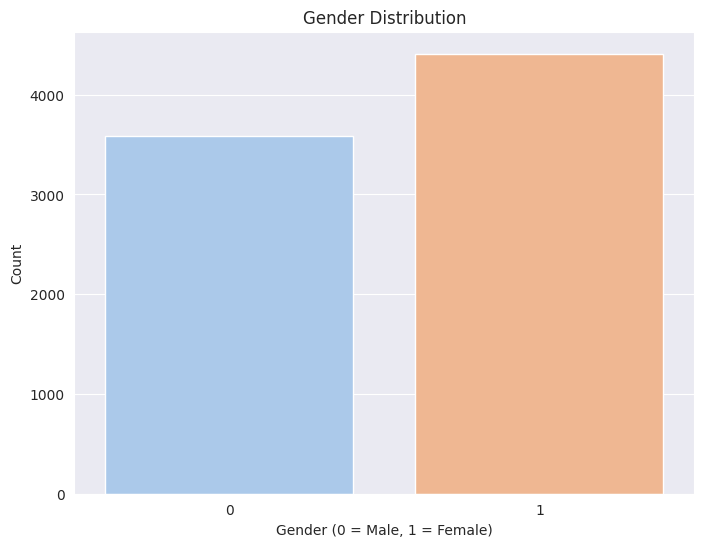

<ipython-input-1-e6bc85cffa18>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=age_groups, palette='coolwarm')


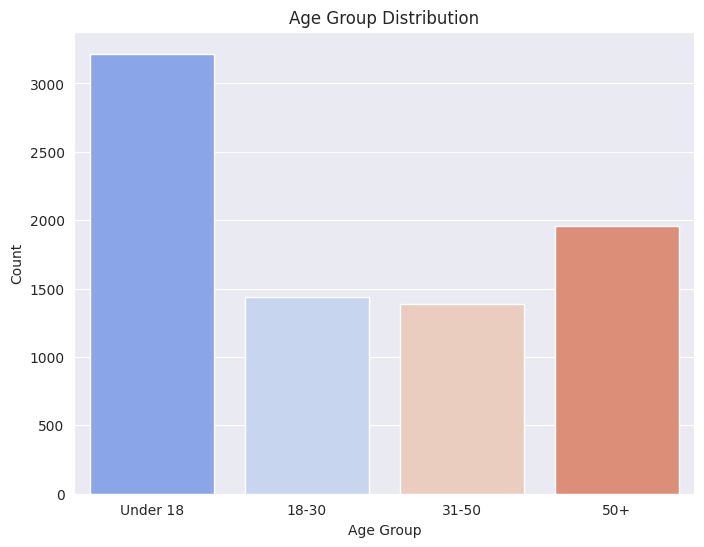

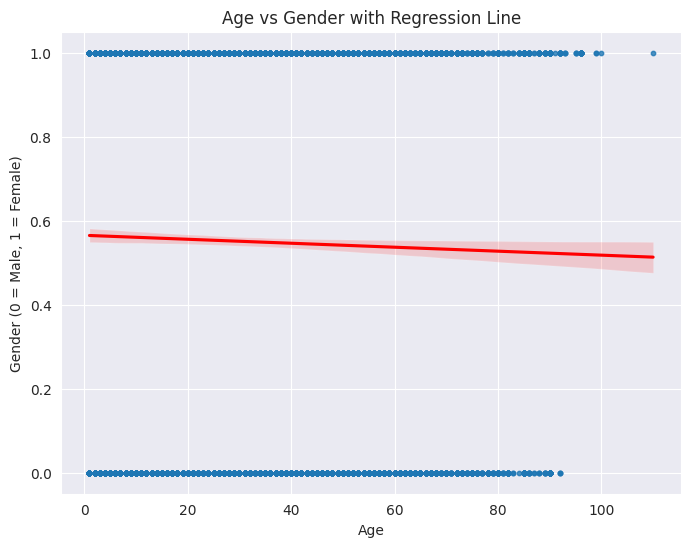

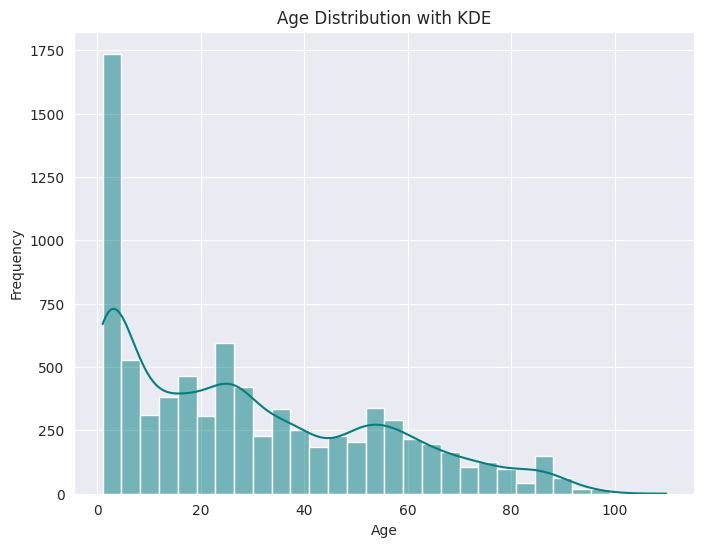

<Figure size 1000x800 with 0 Axes>

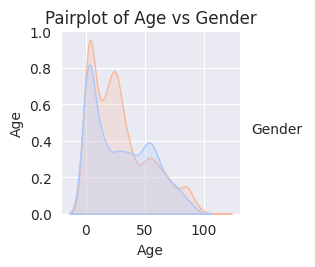

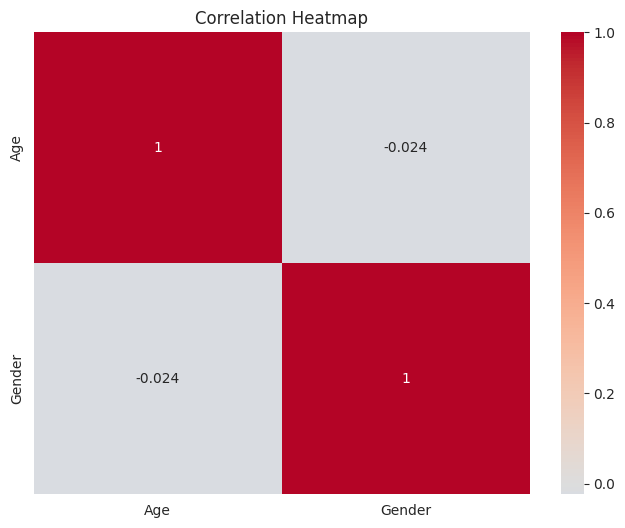

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform

# Download UTKFace dataset using KaggleHub
import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')
print('Data source import complete.')

# Correct the path to where the dataset was downloaded
image_folder_path = os.path.join(jangedoo_utkface_new_path, "crop_part1")

# Load images, ages, and genders
images = []
ages = []
genders = []

for i in os.listdir(image_folder_path)[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    img = Image.open(os.path.join(image_folder_path, i))
    img = img.resize((128, 128))  # Resize to 128x128 for easier processing
    img_array = img_to_array(img)
    images.append(img_array)

# Convert lists to numpy arrays
images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)

# Normalize image data
images = images / 255.0  # Normalize images to the range [0, 1]

# No need for one-hot encoding for gender, directly use the labels
y_gender = genders

# Set up the DataFrame for insights
df = pd.DataFrame({'Age': ages, 'Gender': genders})

# Plot Gender Distribution with cool styling
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(x=genders, palette='pastel')
plt.title("Gender Distribution")
plt.xlabel("Gender (0 = Male, 1 = Female)")
plt.ylabel("Count")
plt.show()

# Age Group Distribution using cool palette
age_groups = pd.cut(ages, bins=[0, 18, 30, 50, 100], labels=["Under 18", "18-30", "31-50", "50+"], right=False)

plt.figure(figsize=(8, 6))
sns.countplot(x=age_groups, palette='coolwarm')
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

# Age vs Gender with cool scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=ages, y=genders, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.title("Age vs Gender with Regression Line")
plt.xlabel("Age")
plt.ylabel("Gender (0 = Male, 1 = Female)")
plt.show()

# Additional Insights: Age Distribution with KDE using a cool color palette
plt.figure(figsize=(8, 6))
sns.histplot(ages, bins=30, kde=True, color='teal')
plt.title("Age Distribution with KDE")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Pairplot: Visualizing Age and Gender relationship
plt.figure(figsize=(10, 8))
sns.pairplot(df, hue="Gender", palette='coolwarm', markers=["o", "s"])
plt.title("Pairplot of Age vs Gender")
plt.show()

# Heatmap: Correlation Matrix of features (although we have few features, let's visualize them)
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [4]:
print(ages)

[49  7 30 ... 18  4 10]


In [5]:
# Split data into training and test sets
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    images, y_gender, ages, test_size=0.2, random_state=42)

In [12]:
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
                                     GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Model Configuration
input_size = (128, 128, 3)  # Adjust input shape for RGB images
inputs = Input(input_size)

# Convolutional Blocks
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
           kernel_regularizer=l2(0.001))(inputs)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
           kernel_regularizer=l2(0.001))(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
           kernel_regularizer=l2(0.001))(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

# Global Average Pooling to reduce overfitting
X = GlobalAveragePooling2D()(X)

# Fully Connected Layers
dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(X)
dropout_1 = Dropout(0.5)(dense_1)

# Gender Output: 1 unit, sigmoid activation for binary classification
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)

# Age Output: 1 unit, linear activation for regression
output_2 = Dense(1, activation='relu', name='age_output')(dropout_1)

# Final model with two outputs
model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Compile the model with a reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Print model summa


In [13]:
# Train the model
history = model.fit(X_train,
                    {'gender_output': y_gender_train, 'age_output': y_age_train},  # Labels for both outputs
                    validation_data=(X_test, {'gender_output': y_gender_test, 'age_output': y_age_test}),  # Validation data for both outputs
                    epochs=1,
                    batch_size=64)

100/100 [==============================] - 623s 6s/step - loss: 1010.2366 - gender_output_loss: 0.8515 - age_output_loss: 1008.2333 - gender_output_accuracy: 0.5200 - age_output_mae: 23.5167 - val_loss: 1494.7242 - val_gender_output_loss: 0.6785 - val_age_output_loss: 1492.8917 - val_gender_output_accuracy: 0.5681 - val_age_output_mae: 29.2752


In [41]:
model.save('age-gender-detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
results = model.evaluate(X_test, {'gender_output': y_gender_test, 'age_output':   y_age_test})

50/50 [==============================] - 38s 747ms/step - loss: 1494.7244 - gender_output_loss: 0.6785 - age_output_loss: 1492.8916 - gender_output_accuracy: 0.5681 - age_output_mae: 29.2752


In [46]:
# Unpack the first 5 values
test_loss, test_gender_accuracy, test_age_mae, extra_metric_1, extra_metric_2 =    results

In [51]:
print("Test Loss:", test_loss)
print("Test Gender Accuracy:", test_gender_accuracy)
print("Test Age MAE:", test_age_mae)
print("Extra Metric 1:", extra_metric_1)
print("Extra Metric 2:", extra_metric_2)

Test Loss: 1494.724365234375
Test Gender Accuracy: 0.6784998178482056
Test Age MAE: 1492.8916015625
Extra Metric 1: 0.5681250095367432
Extra Metric 2: 29.275165557861328


In [52]:
result = model.predict(X_test)

50/50 [==============================] - 37s 743ms/step


In [50]:
print(result)

[array([[0.61557925],
       [0.537979  ],
       [0.55912614],
       ...,
       [0.6403498 ],
       [0.58671004],
       [0.60424554]], dtype=float32), array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)]


In [35]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('age-gender-detection.h5')


In [38]:
# Make predictions with the model
predictions = loaded_model.predict(X_test)

# Extract gender and age predictions from the output
print(predictions)


50/50 [==============================] - 37s 739ms/step
[array([[0.61557925],
       [0.537979  ],
       [0.55912614],
       ...,
       [0.6403498 ],
       [0.58671004],
       [0.60424554]], dtype=float32), array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)]


In [40]:
import numpy as np

# Example prediction with shape (2, 1600, 1)
# predictions = np.array([[...], [...]])

# Find the index of the maximum value for each sample (across the last dimension)
max_indices = np.argmax(predictions, axis=2)

print("Max indices:", max_indices)


Max indices: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform

# Download UTKFace dataset using KaggleHub
import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')
print('Data source import complete.')

# Correct the path to where the dataset was downloaded
image_folder_path = os.path.join(jangedoo_utkface_new_path, "crop_part1")

# Load images, ages, and genders
images = []
ages = []
genders = []

# Load data
for i in os.listdir(image_folder_path)[0:8000]:  # Limit to first 8000 images for now
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    img = Image.open(os.path.join(image_folder_path, i))
    img = img.resize((128, 128))  # Resize to 128x128 for easier processing
    img_array = img_to_array(img)
    images.append(img_array)

# Convert lists to numpy arrays
images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)

# Normalize image data
images = images / 255.0  # Normalize images to the range [0, 1]

# Set up the DataFrame for insights
df = pd.DataFrame({'Age': ages, 'Gender': genders})

# Split data into training and test sets
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    images, genders, ages, test_size=0.2, random_state=42)

# Model Configuration
input_size = (128, 128, 3)  # Adjust input shape for RGB images
inputs = Input(input_size)

# Convolutional Blocks
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(X)
X = MaxPooling2D((2, 2))(X)

# Flatten the output from Conv layers
X = Flatten()(X)

# Fully Connected Layers
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.5)(dense_1)

# Gender Output: 1 unit, sigmoid activation for binary classification
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)

# Age Output: 1 unit, linear activation for regression
output_2 = Dense(1, activation='relu', name='age_output')(dropout_1)

# Final model with two outputs
model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Compile the model with a reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train,
                    {'gender_output': y_gender_train, 'age_output': y_age_train},  # Labels for both outputs
                    validation_data=(X_test, {'gender_output': y_gender_test, 'age_output': y_age_test}),  # Validation data for both outputs
                    epochs=10,  # Train for more epochs for better results
                    batch_size=128)



Data source import complete.
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 128, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 64)           0         ['conv2d_12[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 64, 64, 128)          73856

In [ ]:
# Model Evaluation (for test set)
results = model.evaluate(X_test,
                         {'gender_output': y_gender_test, 'age_output': y_age_test})

# Unpack the results
test_loss, gender_output_loss, age_output_loss, test_gender_accuracy, test_age_mae = results

# Print the evaluation results
print("Test Loss:", test_loss)
print("Gender Output Loss:", gender_output_loss)
print("Age Output Loss:", age_output_loss)
print("Test Gender Accuracy:", test_gender_accuracy)
print("Test Age MAE:", test_age_mae)


In [ ]:
print("Test Loss:", test_loss)
print("Test Gender Accuracy:", test_gender_accuracy)
print("Test Age MAE:", test_age_mae)



In [ ]:
# Display some sample predictions
sample_idx = np.random.randint(0, len(X_test), 5)  # Random indices for sample display

for idx in sample_idx:
    img = X_test[idx] * 255.0  # Rescale back to [0, 255]
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = Image.fromarray(img)

    gender_pred, age_pred = model.predict(np.expand_dims(X_test[idx], axis=0))

    plt.imshow(img)
    plt.title(f"Predicted Gender: {'Male' if gender_pred > 0.5 else 'Female'}, Predicted Age: {int(age_pred)}")
    plt.axis('off')
    plt.show()


In [ ]:
model.save("age.h5")
